## Prerequisites to run:
- clone https://github.com/crowdbotp/OpenTraj into the current folder

In [1]:
import os, yaml
import sys
sys.path.insert(0, os.path.abspath(os.getcwd()) + '/OpenTraj/opentraj') # Anaconda python can't find the toolkit path without this for some reason

from toolkit.loaders.loader_edinburgh import load_edinburgh
from matplotlib import pyplot as plt
import numpy as np
np.random.seed(42)

from sklearn.linear_model import LinearRegression


In [2]:
opentraj_root = './OpenTraj/'
selected_day = '01Sep' # 3 days of data in total, ['01Jul', '01Aug', '01Sep']
edinburgh_path = os.path.join(opentraj_root, 'datasets/Edinburgh/annotations', 'tracks.%s.txt' % selected_day)
traj_dataset = load_edinburgh(edinburgh_path, title="Edinburgh", 
                              use_kalman=False, scene_id=selected_day, sampling_rate=4)

/Users/kriis/ut/MSc/trajectory-forecasting/OpenTraj/opentraj/toolkit/loaders/loader_edinburgh.py:56: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  data = pd.read_csv(file, sep="\n|=", header=None,index_col=None)


reading:./OpenTraj/datasets/Edinburgh/annotations/tracks.01Sep.txt


100%|██████████| 2342/2342 [01:46<00:00, 21.94it/s]


Warning! too big dt in [Edinburgh]
finish


### Helper functions

In [3]:
data = traj_dataset.data

# Sample train and test data for pos_x and pos_y, each slice with num_steps length
def generate_data(data, begin_idx, agent_id, num_steps=5):
    sample_x = data["pos_x"].loc[data["agent_id"]==agent_id][begin_idx:begin_idx+num_steps].values
    sample_y = data["pos_y"].loc[data["agent_id"]==agent_id][begin_idx:begin_idx+num_steps].values

    test_x = data["pos_x"].loc[data["agent_id"]==agent_id][begin_idx+num_steps:begin_idx+2*num_steps].values
    test_y = data["pos_y"].loc[data["agent_id"]==agent_id][begin_idx+num_steps:begin_idx+2*num_steps].values
    
    return sample_x, sample_y, test_x, test_y

def generate_velocity_data(data, begin_idx, agent_id, num_steps=5):
    sample_vel_x = data["vel_x"].loc[data["agent_id"]==agent_id][begin_idx:begin_idx+num_steps].values
    sample_vel_y = data["vel_y"].loc[data["agent_id"]==agent_id][begin_idx:begin_idx+num_steps].values
    
    test_vel_x = data["vel_x"].loc[data["agent_id"]==agent_id][begin_idx+num_steps:begin_idx+2*num_steps].values
    test_vel_y = data["vel_y"].loc[data["agent_id"]==agent_id][begin_idx+num_steps:begin_idx+2*num_steps].values
    
    return sample_vel_x, sample_vel_y, test_vel_x, test_vel_y

def plot_predictions(sample_x, sample_y, test_x, test_y, pred_x, pred_y):
    plt.axes().set_aspect('equal')
        
    plt.plot(np.append(sample_x, pred_x), np.append(sample_y, pred_y), label="fitted polynomial", color='r')
    plt.plot(np.append(sample_x, test_x), np.append(sample_y,test_y), label="actual data", color='b')
    
    plt.scatter(np.append(sample_x, pred_x), np.append(sample_y, pred_y), label="fitted polynomial", color='r')
    plt.scatter(np.append(sample_x, test_x), np.append(sample_y,test_y), label="actual data", color='b')

    #plt.scatter(sample_x[0], sample_y[0], color='b')
    #plt.scatter(sample_x[-1], sample_y[-1], color='gray')
    #plt.scatter(pred_x[0], pred_y[0], color='r')
    

    # Comment out the following if you want to see all generated trajectories
    #for i in range(len(pred_x_list)):
    #    plt.plot(np.append(sample_x,pred_x_list[i]), np.append(sample_y,pred_y_list[i]), label="fitted polynomial")

    #plt.legend()
    plt.show()
    
def calculate_error(pred_x, pred_y, test_x, test_y):
    
    # FDE
    final_displacement_x = pred_x[-1] - test_x[-1]
    final_displacement_y = pred_y[-1] - test_y[-1]
    FDE = np.sqrt(final_displacement_x**2 + final_displacement_y**2)
    
    # MSE
    abs_error_x = pred_x - test_x
    abs_error_y = pred_y - test_y
    
    MSE = np.mean(np.square(abs_error_x)) + np.mean(np.square(abs_error_y))
    
    return FDE, MSE

In [4]:
NUM_OF_STEPS = 5

# Removing any agents which don't have enough steps for model fitting and predicting
agent_ids = data.agent_id.unique()
for agent_id in agent_ids:
    if len(data[data.agent_id == agent_id]) < 2*NUM_OF_STEPS:
        data = data[data.agent_id != agent_id]
agent_ids = data.agent_id.unique()

### Method with OLS t -> v<sub>x</sub>, t -> v<sub>y</sub> and s<sub>x</sub> -> x, s<sub>y</sub> -> y
OLS from time to velocity (for x and y separately), distance (x and y separately) (s) from velocity, OLS from distances to x and y coordinates  
s<sub>0</sub> = 0  
s<sub>i</sub> = s<sub>i-1</sub> + v<sub>i-1</sub>

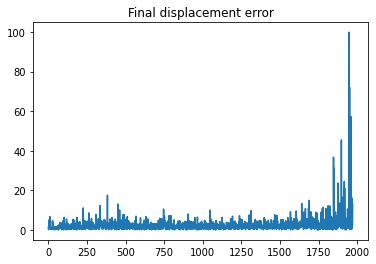

Average FDE:  2.5068635509763366
Average MSE:  8.995875587113538


In [5]:
def lin_reg_t_to_v(data, agent_id, step, plot_data=False):
    # Generate 'seen' and 'unseen' data
    sample_pos_x, sample_pos_y, test_pos_x, test_pos_y = generate_data(data, 0, agent_id, step)
    sample_vel_x, sample_vel_y, test_vel_x, test_vel_y = generate_velocity_data(data, 0, agent_id, step)
    
    # OLS t -> v, then s_i = s_i-1 + v_i-1
        
    # time ranges
    time_range_train = np.array(range(len(sample_pos_x))).reshape(-1,1)
    time_range_pred = np.array(range(len(sample_pos_x), 2*len(sample_pos_x))).reshape(-1,1)
    
    # OLS t -> v
    fitted_vel_x = LinearRegression().fit(time_range_train, sample_vel_x)
    fitted_vel_y = LinearRegression().fit(time_range_train, sample_vel_y)
    
    # velocity predictions
    pred_vel_x = fitted_vel_x.predict(time_range_pred)
    pred_vel_y = fitted_vel_y.predict(time_range_pred)
    
    # train s values
    train_s_x = [0]
    train_s_y = [0]
    for i in range(1, len(sample_vel_x)):
        train_s_x.append(train_s_x[i-1] + sample_vel_x[i-1])
        train_s_y.append(train_s_y[i-1] + sample_vel_y[i-1])
        
    # test s values
    test_s_x = [train_s_x[-1] + sample_vel_x[-1]]
    test_s_y = [train_s_y[-1] + sample_vel_y[-1]]
    for i in range(1, len(sample_vel_x)):
        test_s_x.append(test_s_x[i-1] + pred_vel_x[i-1])
        test_s_y.append(test_s_y[i-1] + pred_vel_y[i-1])
        
    # OLS s_x -> x; s_y -> y
    fitted_x = LinearRegression().fit(np.array(train_s_x).reshape(-1,1), sample_pos_x)
    fitted_y = LinearRegression().fit(np.array(train_s_y).reshape(-1,1), sample_pos_y)
    
    pred_x = fitted_x.predict(np.array(test_s_x).reshape(-1,1))
    pred_y = fitted_y.predict(np.array(test_s_y).reshape(-1,1))

    
    # Plotting
    if (plot_data):
        plot_predictions(sample_pos_x, sample_pos_y, test_pos_x, test_pos_y, pred_x, pred_y)
    
    # Error calculation
    FDE, MSE = calculate_error(pred_x, pred_y, test_pos_x, test_pos_y)
    return FDE, MSE


# Running the model
all_FDE = []
all_MSE = []
for i in agent_ids:
    run_FDE, run_MSE = lin_reg_t_to_v(data, agent_id=i, step=NUM_OF_STEPS)
    all_FDE.append(run_FDE)
    all_MSE.append(run_MSE)


plt.plot(all_FDE)
plt.title("Final displacement error")
plt.show()

print("Average FDE: ", np.mean(all_FDE))
print("Average MSE: ", np.mean(all_MSE))

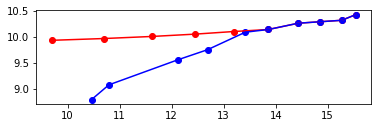

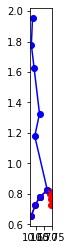

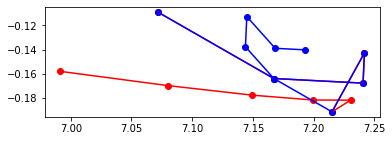

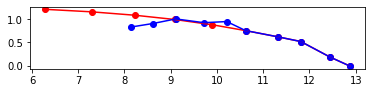

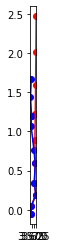

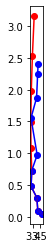

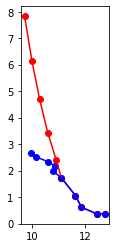

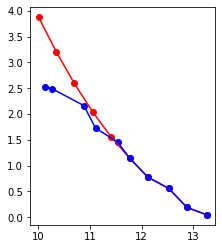

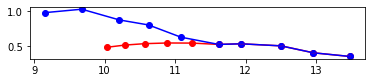

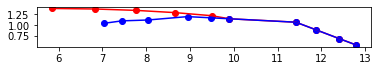

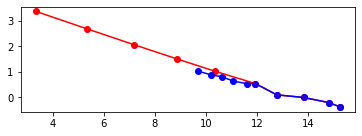

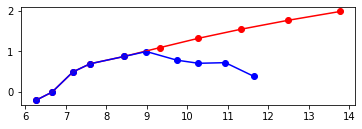

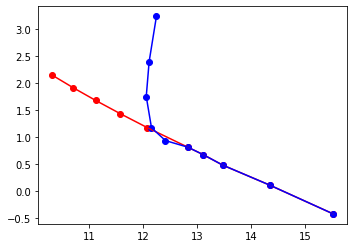

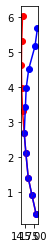

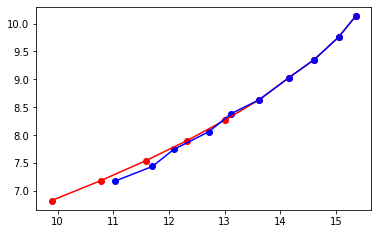

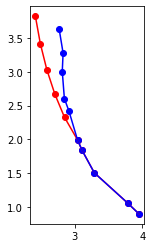

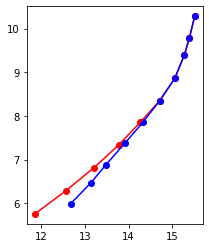

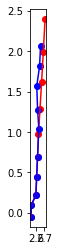

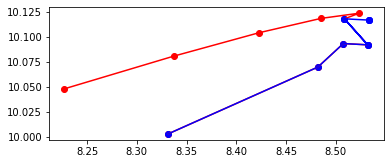

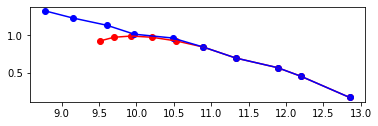

In [6]:
# Checking some plot examples
for i in agent_ids[:20]:
    lin_reg_t_to_v(data, agent_id=i, step=NUM_OF_STEPS, plot_data=True)

In [8]:
print(a)

[[5]
 [6]
 [7]
 [8]
 [9]]


### Method with (unified) OLS t -> v and s-> x, s -> y
OLS from time to velocity (unified), distance (unified) (s) from velocity, OLS from distances to x and y coordinates  
s<sub>0</sub> = 0  
s<sub>i</sub> = s<sub>i-1</sub> + v<sub>i-1</sub>

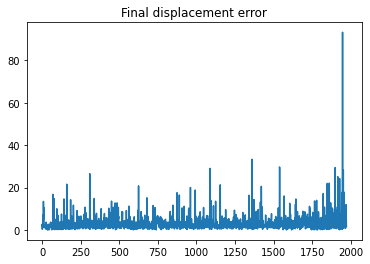

Average FDE:  3.2387953890157455
Average MSE:  9.516532889035016


In [38]:
def lin_reg_t_to_v(data, agent_id, step, plot_data=False, plot_validation_data=False):
    # Generate 'seen' and 'unseen' data
    sample_pos_x, sample_pos_y, test_pos_x, test_pos_y = generate_data(data, 0, agent_id, step)
    sample_vel = [(sample_pos_x[i]-sample_pos_x[i-1])**2 + (sample_pos_y[i]-sample_pos_y[i-1])**2 for i in range(1, len(sample_pos_x))]
    # OLS t -> v, then s_i = s_i-1 + v_i-1
        
    # time ranges
    time_range_train = np.array(range(len(sample_pos_x))).reshape(-1,1)
    time_range_pred = np.array(range(len(sample_pos_x), 2*len(sample_pos_x))).reshape(-1,1)
    
    # OLS t -> v
    fitted_vel = LinearRegression().fit(time_range_train[:-1], sample_vel)
    
    # velocity predictions (predict based on the last train time and all test times)
    pred_vel = fitted_vel.predict(np.append(time_range_train[-1], time_range_pred[:-1]).reshape(-1,1))
    
    # train s values
    train_s = [0]
    for i in range(1, len(sample_vel)+1):
        train_s.append(train_s[i-1] + sample_vel[i-1])
        
    # test s values
    test_s = [train_s[-1] + pred_vel[0]] # first test s is the last train s + velocity predicted based on last train s
    for i in range(1, len(sample_vel)+1):
        test_s.append(test_s[i-1] + pred_vel[i]) 
    
    
    # OLS s -> x; s -> y
    fitted_x = LinearRegression().fit(np.array(train_s).reshape(-1,1), sample_pos_x)
    fitted_y = LinearRegression().fit(np.array(train_s).reshape(-1,1), sample_pos_y)
    
    pred_x = fitted_x.predict(np.array(test_s).reshape(-1,1))
    pred_y = fitted_y.predict(np.array(test_s).reshape(-1,1))

    
    # Plotting
    if (plot_data):
        plot_predictions(sample_pos_x, sample_pos_y, test_pos_x, test_pos_y, pred_x, pred_y)
        
    if (plot_validation_data):
        plt.plot(np.append(time_range_train, time_range_pred), np.append(train_s, test_s))
        plt.title("time / distance")
        plt.xlabel("t")
        plt.ylabel("s")
        plt.show()
        
        plt.plot(np.append(train_s, test_s), np.append(sample_pos_x, pred_x), label="s/pos x")
        plt.plot(np.append(train_s, test_s), np.append(sample_pos_y, pred_y), label="s/pos y")
        plt.legend()
        plt.title("distance / x & y pos")
        plt.xlabel("s")
        plt.ylabel("coordinate")
        plt.show()
    
    # Error calculation
    FDE, MSE = calculate_error(pred_x, pred_y, test_pos_x, test_pos_y)
    return FDE, MSE


# Running the model
all_FDE = []
all_MSE = []
for i in agent_ids:
    run_FDE, run_MSE = lin_reg_t_to_v(data, agent_id=i, step=NUM_OF_STEPS)
    all_FDE.append(run_FDE)
    all_MSE.append(run_MSE)


plt.plot(all_FDE)
plt.title("Final displacement error")
plt.show()

print("Average FDE: ", np.mean(all_FDE))
print("Average MSE: ", np.mean(all_MSE))

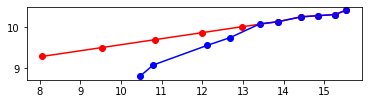

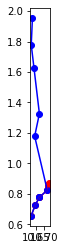

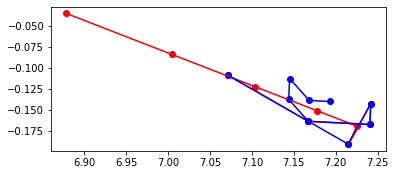

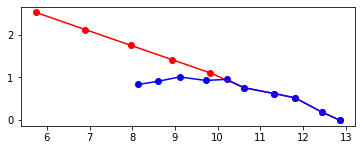

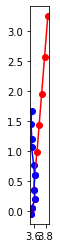

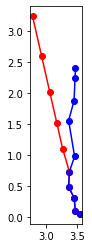

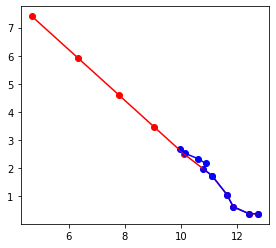

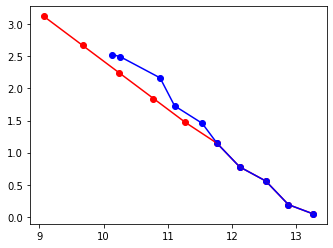

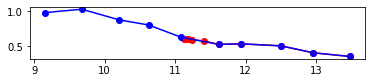

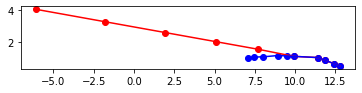

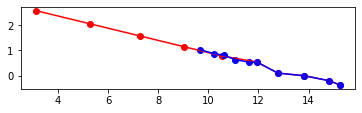

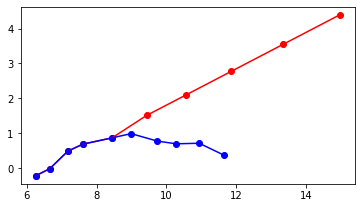

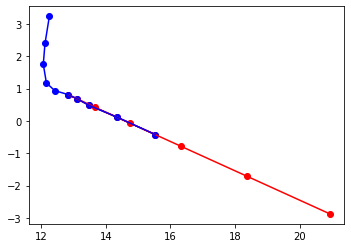

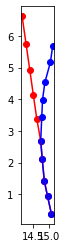

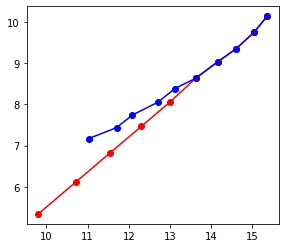

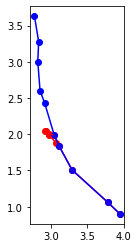

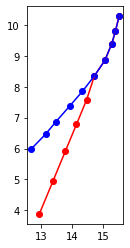

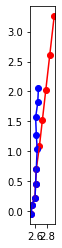

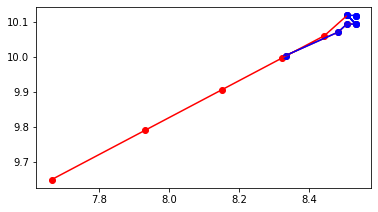

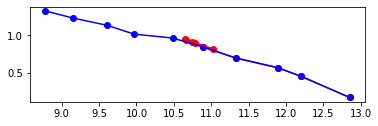

In [39]:
# Checking some plot examples
for i in agent_ids[:20]:
    lin_reg_t_to_v(data, agent_id=i, step=NUM_OF_STEPS, plot_data=True)

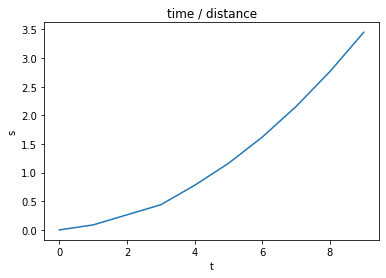

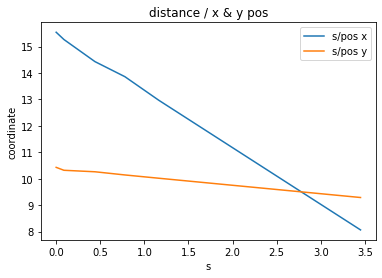

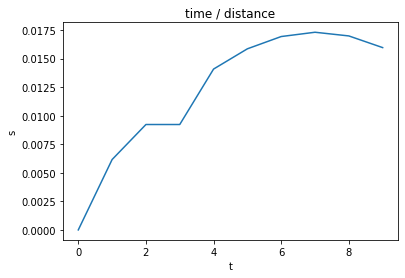

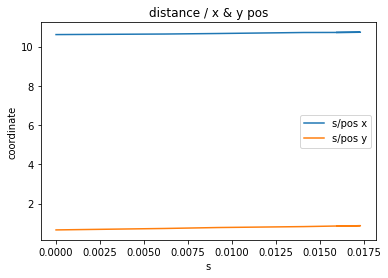

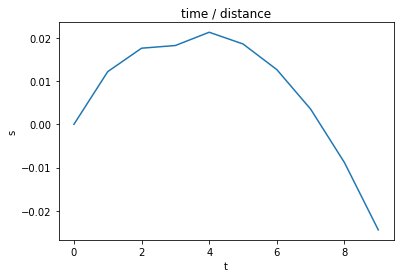

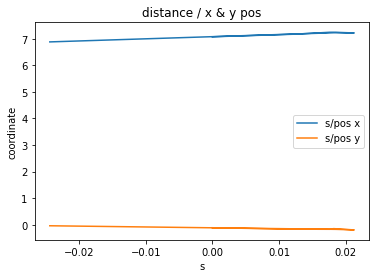

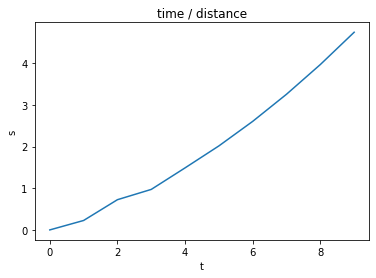

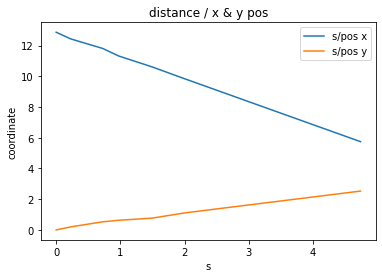

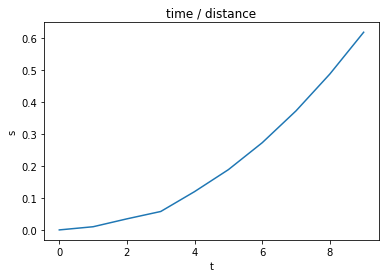

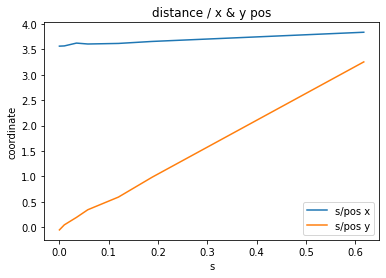

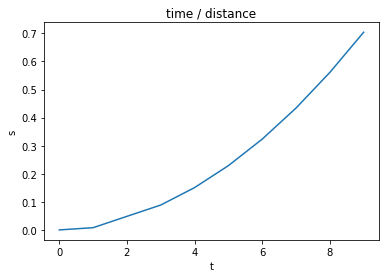

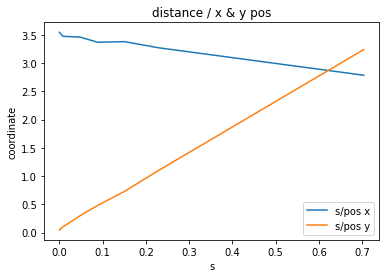

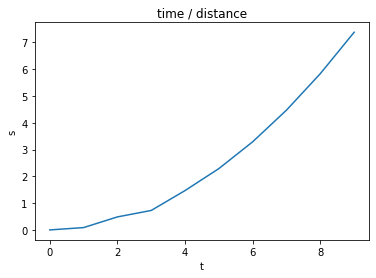

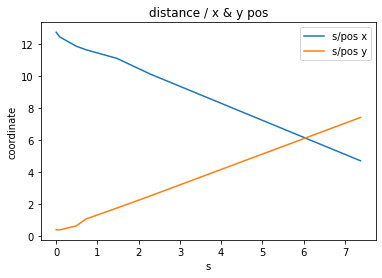

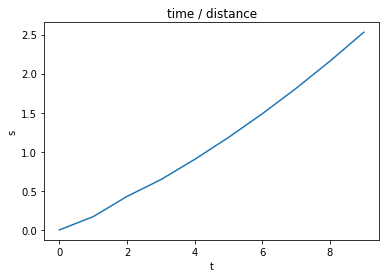

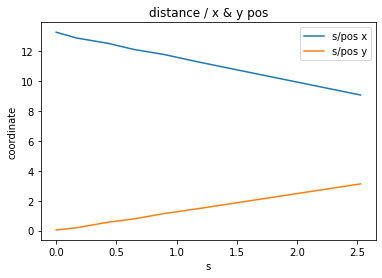

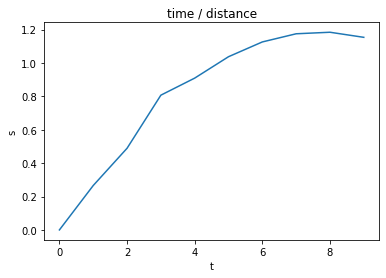

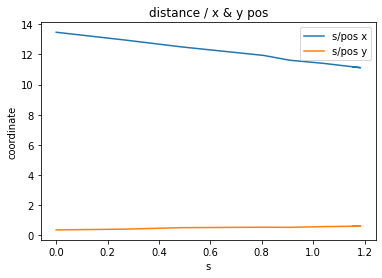

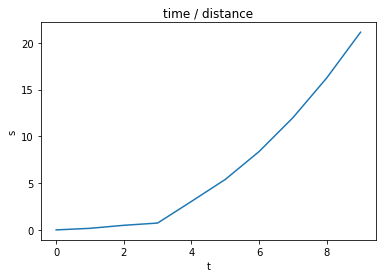

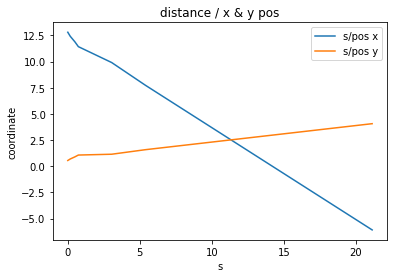

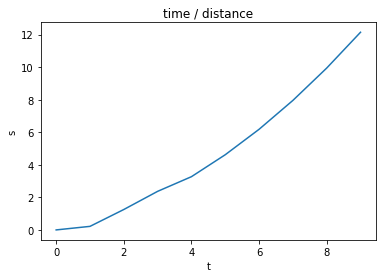

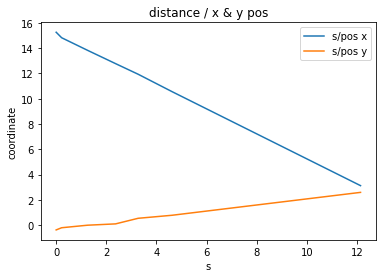

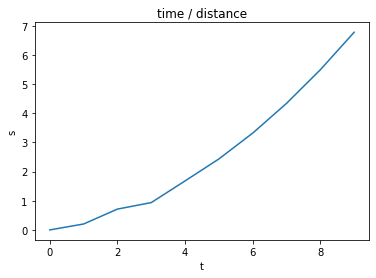

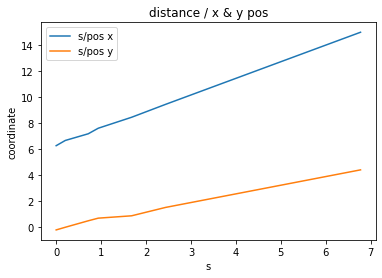

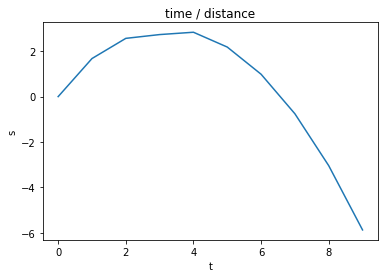

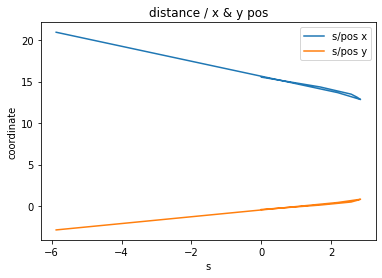

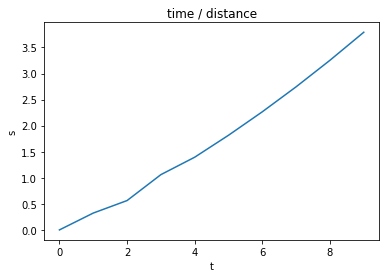

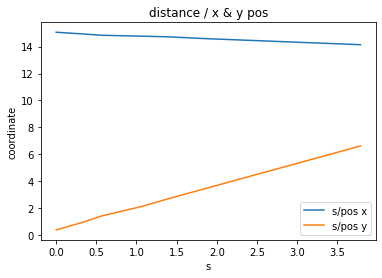

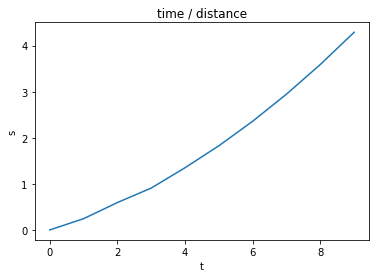

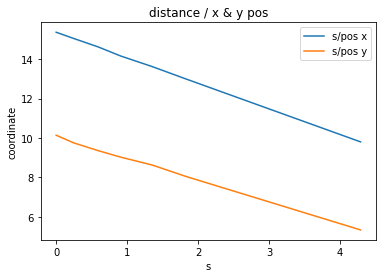

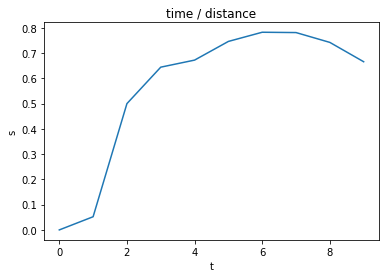

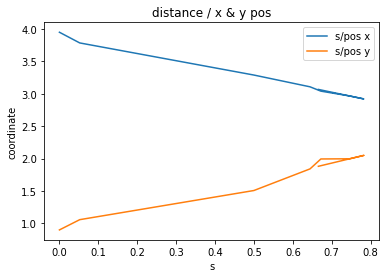

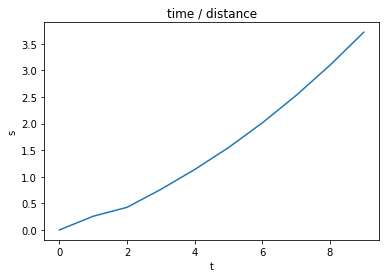

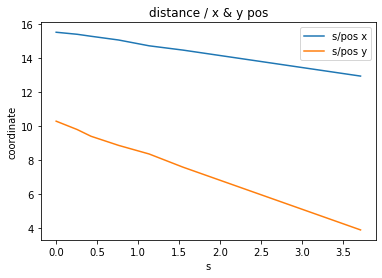

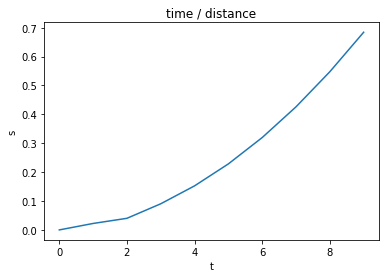

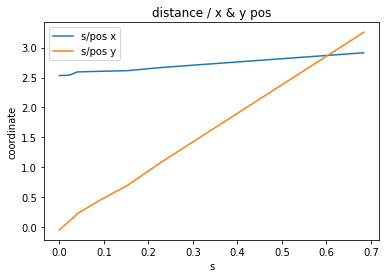

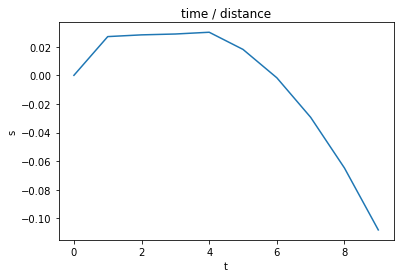

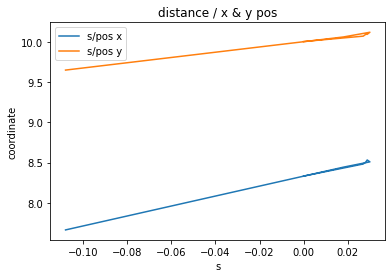

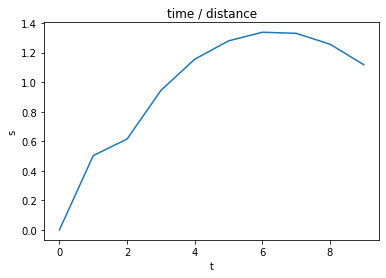

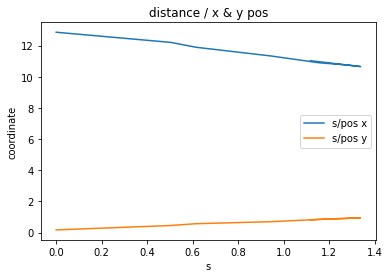

In [40]:
# validating the dependencies between t / s (graph should be parabolic) and s / x & s / y (should be linear)
for i in agent_ids[:20]:
    lin_reg_t_to_v(data, agent_id=i, step=NUM_OF_STEPS, plot_validation_data=True)